# Análise de Sentimentos em Tweets usando GRU

Este notebook implementa uma Rede Neural Recorrente (RNN) usando LSTM para análise de sentimentos em postagens do Twitter.

## Objetivos:
- Pré-processar dados de tweets
- Implementar uma arquitetura GRU
- Treinar o modelo para classificação de sentimentos (positivo/negativo)
- Avaliar o desempenho e apresentar resultados

In [ ]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Para pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import zipfile
import urllib.request
from pathlib import Path

os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras / TensorFlow
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"Keras version: {keras.__version__}")
print(f"Tensorflow version: {tf.__version__}")

Keras version: 3.10.0
Tensorflow version: 2.19.0


In [ ]:
# Carregamento dos dados
print("Carregando dados...")
try:
    # Define the path to your dataset
    dataset_path = 'data.csv'

    # Check if the file exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")

    # Load the entire dataset to sample from it
    # Warning: This might consume significant memory for a large dataset.
    # If memory is an issue, consider loading in chunks or using a different approach.
    print("Attempting to load the full dataset for sampling...")
    df_full = pd.read_csv(dataset_path, encoding='latin-1', header=None) # Load without header initially

    # Assuming the sentiment column is the first one (index 0) and tweet text is the last (index 5)
    # Let's verify the columns by looking at the first few rows
    print("\nFirst 5 rows of the full dataset (before assigning headers):")
    print(df_full.head())

    # Assign correct column names based on observation
    df_full.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

    # Ensure sentiment column is numeric and handle potential errors
    df_full['sentiment'] = pd.to_numeric(df_full['sentiment'], errors='coerce')
    df_full.dropna(subset=['sentiment'], inplace=True) # Remove rows where sentiment couldn't be converted

    # Filter for sentiment 0 (negative) and 4 (positive)
    df_negative = df_full[df_full['sentiment'] == 0].sample(n=50000, random_state=42, replace=False)
    df_positive = df_full[df_full['sentiment'] == 4].sample(n=50000, random_state=42, replace=False)

    # Combine and shuffle
    df = pd.concat([df_negative, df_positive], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset carregado com sucesso! Shape: {df.shape}")

    # Verificando as primeiras linhas
    print("\nPrimeiras 5 linhas do dataset (amostra balanceada):")
    print(df.head())

    # Informações sobre o dataset
    print(f"\nInformações do dataset:")
    print(df.info())

    # Verificando valores únicos na coluna de sentimento
    print(f"\nValores únicos na coluna de sentimento:")
    print(df['sentiment'].value_counts())


except FileNotFoundError as e:
    print(f"Erro: {e}. Por favor, verifique se o arquivo 'data.csv' está na pasta 'DATA'.")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    print("Tentando descobrir a estrutura do arquivo...")

    # Read only the first few lines to understand the structure
    try:
        sample = pd.read_csv('DATA/data.csv', encoding='latin-1', nrows=10, header=None)
        print("\nSample of the dataset:")
        print(sample)
    except Exception as sample_e:
        print(f"Could not read sample of the file: {sample_e}")

Carregando dados...
Attempting to load the full dataset for sampling...

First 5 rows of the full dataset (before assigning headers):
   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  
Dataset carregado com sucesso! Shape: (100000, 6)

Primeiras 5 linhas do 

In [ ]:
# Função para pré-processamento de texto
def preprocess_text(text):
    """
    Função para limpar e pré-processar os textos dos tweets
    """
    if pd.isna(text):
        return ""

    # Converter para string e lowercase
    text = str(text).lower()

    # Remover URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remover menções (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Remover hashtags (# mas manter o texto)
    text = re.sub(r'#', '', text)

    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Preparar os dados
print("Preparando dados para análise...")

# Assumindo que a primeira coluna é o sentimento (0=negativo, 4=positivo)
# e a última coluna é o texto do tweet
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Converter sentimento: 0 -> 0 (negativo), 4 -> 1 (positivo)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# Aplicar pré-processamento
print("Aplicando pré-processamento no texto...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Remover textos vazios
df = df[df['cleaned_text'].str.len() > 0]

print(f"Dataset após pré-processamento: {df.shape}")
print(f"Distribuição de sentimentos:")
print(df['sentiment'].value_counts())

# Mostrar exemplos de textos limpos
print("\nExemplos de textos antes e depois do pré-processamento:")
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i]}")
    print(f"Limpo: {df['cleaned_text'].iloc[i]}")

Preparando dados para análise...
Aplicando pré-processamento no texto...
Dataset após pré-processamento: (99760, 7)
Distribuição de sentimentos:
sentiment
0    49894
1    49866
Name: count, dtype: int64

Exemplos de textos antes e depois do pré-processamento:

Original: @stargazer60 that's awesome 
Limpo: thats awesome

Original: @cunningstunts22  yes... i am!  
Limpo: yes i am

Original: N my bed aaallll alone 
Limpo: n my bed aaallll alone


In [ ]:
# Tokenização e preparação das sequências
print("Preparando tokenização...")

# Parâmetros
MAX_VOCAB_SIZE = 40000  # Tamanho máximo do vocabulário
MAX_SEQUENCE_LENGTH = 70  # Tamanho máximo das sequências
EMBEDDING_DIM = 100  # Dimensão dos embeddings

# Separar features e target
X = df['cleaned_text'].values
y = df['sentiment'].values

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de treino: {len(X_train)} exemplos")
print(f"Conjunto de teste: {len(X_test)} exemplos")

# Tokenização
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Converter textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Shape dos dados de treino: {X_train_pad.shape}")
print(f"Shape dos dados de teste: {X_test_pad.shape}")

# Informações sobre o vocabulário
vocab_size = len(tokenizer.word_index) + 1  # +1 para o token de padding
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Tamanho efetivo usado: {min(vocab_size, MAX_VOCAB_SIZE)}")

# Mostrar exemplo de sequência
print(f"\nExemplo de texto original: {X_train[0]}")
print(f"Sequência correspondente: {X_train_seq[0][:10]}...")  # Primeiros 10 tokens
print(f"Sequência com padding: {X_train_pad[0][:15]}...")  # Primeiros 15 tokens

Preparando tokenização...
Conjunto de treino: 79808 exemplos
Conjunto de teste: 19952 exemplos
Shape dos dados de treino: (79808, 70)
Shape dos dados de teste: (19952, 70)
Tamanho do vocabulário: 55573
Tamanho efetivo usado: 40000

Exemplo de texto original: i feeeel properr bad but it was ridiculous doing all weekend working
Sequência correspondente: [2, 13403, 19553, 108, 20, 10, 27, 2771, 180, 36]...
Sequência com padding: [    2 13403 19553   108    20    10    27  2771   180    36   152   159
     0     0     0]...


In [ ]:
# Carregamento de embeddings pré-treinados (GloVe)
def download_glove_embeddings():
    """
    Baixa e extrai os embeddings GloVe se não estiverem disponíveis
    """
    glove_dir = Path('glove_embeddings')
    glove_file = glove_dir / 'glove.6B.100d.txt'

    if glove_file.exists():
        print("Embeddings GloVe já estão disponíveis localmente.")
        return str(glove_file)

    print("Baixando embeddings GloVe (isso pode demorar alguns minutos)...")
    glove_dir.mkdir(exist_ok=True)

    # URL do GloVe
    glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zip_path = glove_dir / 'glove.6B.zip'

    try:
        # Baixar o arquivo
        urllib.request.urlretrieve(glove_url, zip_path)
        print("Download concluído. Extraindo arquivos...")

        # Extrair o arquivo
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(glove_dir)

        # Remover o arquivo ZIP para economizar espaço
        zip_path.unlink()
        print("Embeddings GloVe baixados e extraídos com sucesso!")

    except Exception as e:
        print(f"Erro ao baixar GloVe: {e}")
        print("Usando embeddings treináveis do zero como fallback...")
        return None

    return str(glove_file)

def load_glove_embeddings(glove_file, word_index, embedding_dim=100):
    """
    Carrega embeddings GloVe e cria matriz de embeddings para o vocabulário
    """
    print("Carregando embeddings GloVe...")

    # Dicionário para armazenar os embeddings
    embeddings_index = {}

    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

        print(f"Carregados {len(embeddings_index)} vetores de palavra.")

        # Criar matriz de embeddings
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        # Preencher a matriz com embeddings GloVe
        found_words = 0
        for word, i in word_index.items():
            if i >= vocab_size:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found_words += 1

        print(f"Encontrados embeddings para {found_words} palavras de {len(word_index)} no vocabulário.")
        print(f"Cobertura do vocabulário: {found_words/len(word_index)*100:.1f}%")

        return embedding_matrix

    except Exception as e:
        print(f"Erro ao carregar GloVe: {e}")
        print("Usando embeddings treináveis do zero como fallback...")
        return None

# Carregar embeddings pré-treinados
print("Preparando embeddings pré-treinados...")

# Tentar baixar e carregar GloVe
glove_file = download_glove_embeddings()
embedding_matrix = None

if glove_file:
    embedding_matrix = load_glove_embeddings(glove_file, tokenizer.word_index, EMBEDDING_DIM)

# Se não conseguiu carregar GloVe, usar embeddings treináveis
use_pretrained = embedding_matrix is not None
print(f"Usando embeddings pré-treinados: {use_pretrained}")

if use_pretrained:
    print(f"Shape da matriz de embeddings: {embedding_matrix.shape}")
else:
    print("Continuando com embeddings treináveis do zero...")

Preparando embeddings pré-treinados...
Embeddings GloVe já estão disponíveis localmente.
Carregando embeddings GloVe...
Carregados 400000 vetores de palavra.
Encontrados embeddings para 29751 palavras de 55572 no vocabulário.
Cobertura do vocabulário: 53.5%
Usando embeddings pré-treinados: True
Shape da matriz de embeddings: (55573, 100)


In [ ]:
# Criação do modelo GRU com embeddings pré-treinados
print("Criando modelo GRU")

# Parâmetros do modelo
GRU_UNITS = 128
DROPOUT_RATE = 0.3  # Reduzido para evitar underfitting
LEARNING_RATE = 0.001  # Reduzido para melhor convergência
L2_REG = 0.01
DENSE_UNITS = 64

def create_improved_gru_model(embedding_matrix=None, vocab_size=None, embedding_dim=100, max_sequence_length=70):
    """
    Cria um modelo GRU aprimorado para análise de sentimentos
    com embeddings pré-treinados ou treináveis
    """
    model = Sequential()

    # Camada de Embedding
    if embedding_matrix is not None:
        # Usar embeddings pré-treinados
        print("Usando embeddings pré-treinados (GloVe)")
        # FIX: Use the actual vocabulary size derived from the embedding matrix shape
        actual_vocab_size = embedding_matrix.shape[0]
        model.add(Embedding(
            input_dim=actual_vocab_size, # Use actual vocabulary size
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            weights=[embedding_matrix],
            trainable=False,  # Congelar embeddings pré-treinados inicialmente
            name='pretrained_embedding'
        ))
    else:
        # Usar embeddings treináveis do zero
        print("Usando embeddings treináveis do zero")
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            name='trainable_embedding'
        ))

    # Primeira camada GRU bidirecional com return_sequences=True
    model.add(Bidirectional(
        GRU(
            GRU_UNITS,
            dropout=DROPOUT_RATE,
            recurrent_dropout=DROPOUT_RATE,
            return_sequences=True,
            kernel_regularizer=l2(L2_REG),
            recurrent_regularizer=l2(L2_REG)
        ),
        name='bidirectional_gru_1'
    ))

    model.add(Bidirectional(
            GRU(
                GRU_UNITS // 2, # Reduzir unidades em camadas mais profundas
                return_sequences=True # Essencial para a camada de pooling
            ),
            name='bidirectional_gru_2'
        )),

    model.add(GlobalAveragePooling1D(name='global_pooling')),

    # Camadas Dense para classificação
    model.add(Dense(DENSE_UNITS, activation='relu', kernel_regularizer=l2(L2_REG))),
    model.add(BatchNormalization()),
    model.add(Dropout(DROPOUT_RATE)),

    # Camada de saída
    model.add(Dense(1, activation='sigmoid', name='output'))

    return model

# Determinar tamanho efetivo do vocabulário
effective_vocab_size = len(tokenizer.word_index) + 1 # Use the actual vocabulary size from the tokenizer

# Criar o modelo com embeddings pré-treinados se disponíveis
model = create_improved_gru_model(
    embedding_matrix=embedding_matrix,
    vocab_size=effective_vocab_size, # Pass the actual vocabulary size
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQUENCE_LENGTH
)

# Construir o modelo para poder contar os parâmetros
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Compilar o modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Mostrar arquitetura do modelo
print("Arquitetura do modelo:")
model.summary()

# Visualizar parâmetros do modelo
print(f"\nParâmetros do modelo:")
print(f"- Tamanho do vocabulário: {effective_vocab_size}")
print(f"- Dimensão dos embeddings: {EMBEDDING_DIM}")
print(f"- Tamanho máximo da sequência: {MAX_SEQUENCE_LENGTH}")
print(f"- Unidades GRU: {GRU_UNITS}")
print(f"- Taxa de dropout: {DROPOUT_RATE}")
print(f"- Taxa de aprendizado: {LEARNING_RATE}")
print(f"- Embeddings pré-treinados: {'Sim (GloVe)' if use_pretrained else 'Não (treináveis)'}")

# Contar parâmetros treináveis
trainable_params = model.count_params()
# Non-trainable params are handled by model.count_params() when layers are set to trainable=False

if use_pretrained:
    non_trainable_embedding_params = 0
    if model.layers[0].name == 'pretrained_embedding' and not model.layers[0].trainable:
         non_trainable_embedding_params = model.layers[0].count_params()

    print(f"- Parâmetros treináveis: {trainable_params - non_trainable_embedding_params:,}")
    print(f"- Parâmetros não-treináveis (embeddings): {non_trainable_embedding_params:,}")
    print(f"- Total de parâmetros: {trainable_params:,}")
else:
    print(f"- Total de parâmetros treináveis: {trainable_params:,}")


# Estratégia de fine-tuning para embeddings pré-treinados
if use_pretrained:
    print(f"\n🔧 ESTRATÉGIA DE FINE-TUNING:")
    print(f"- Fase 1: Treinar com embeddings congelados")
    print(f"- Fase 2: Descongelar embeddings para fine-tuning (opcional)")
    print(f"- Isso permite melhor aproveitamento dos embeddings pré-treinados")

Criando modelo GRU
Usando embeddings pré-treinados (GloVe)
Arquitetura do modelo:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_embedding            │ (None, 70, 100)        │     5,557,300 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_1             │ (None, 70, 256)        │       176,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_gru_2             │ (None, 70, 128)        │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pooling                  │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,866,165 (22.38 MB)

 Trainable params: 308,737 (1.18 MB)

 Non-trainable params: 5,557,428 (21.20 MB)


Parâmetros do modelo:
- Tamanho do vocabulário: 55573
- Dimensão dos embeddings: 100
- Tamanho máximo da sequência: 70
- Unidades GRU: 128
- Taxa de dropout: 0.3
- Taxa de aprendizado: 0.001
- Embeddings pré-treinados: Sim (GloVe)
- Parâmetros treináveis: 308,865
- Parâmetros não-treináveis (embeddings): 5,557,300
- Total de parâmetros: 5,866,165

🔧 ESTRATÉGIA DE FINE-TUNING:
- Fase 1: Treinar com embeddings congelados
- Fase 2: Descongelar embeddings para fine-tuning (opcional)
- Isso permite melhor aproveitamento dos embeddings pré-treinados


In [ ]:
# Treinamento do modelo com estratégia de fine-tuning
print("Iniciando treinamento...")

# Callbacks para melhor treinamento
def create_callbacks(phase=""):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'modelo_gru_sentimentos_weights{phase}_epoch_{{epoch:02d}}.weights.h5',
            save_weights_only=True,
            save_freq='epoch',
            verbose=0
        )
    ]

# Parâmetros de treinamento
BATCH_SIZE = 128
EPOCHS_PHASE1 = 10  # Primeira fase com embeddings congelados
EPOCHS_PHASE2 = 5  # Segunda fase com fine-tuning
VALIDATION_SPLIT = 0.2

# Histórico completo do treinamento
complete_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

if use_pretrained:
    print("=" * 60)
    print("FASE 1: Treinamento com embeddings pré-treinados CONGELADOS")
    print("=" * 60)

    # Garantir que embeddings estão congelados
    model.layers[0].trainable = False
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"Parâmetros treináveis na Fase 1: {model.count_params():,}")

    # Treinar primeira fase
    history_phase1 = model.fit(
        X_train_pad, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_PHASE1,
        validation_split=VALIDATION_SPLIT,
        callbacks=create_callbacks("_phase1"),
        verbose=1
    )

    # Adicionar ao histórico completo
    for key in complete_history.keys():
        complete_history[key].extend(history_phase1.history[key])

    print(f"Fase 1 concluída! Loss final: {history_phase1.history['val_loss'][-1]:.4f}")

    print("\n" + "=" * 60)
    print("FASE 2: Fine-tuning com embeddings DESCONGELADOS")
    print("=" * 60)

    # Descongelar embeddings para fine-tuning
    model.layers[0].trainable = True

    # Usar learning rate menor para fine-tuning
    fine_tune_lr = LEARNING_RATE * 0.1
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(f"Parâmetros treináveis na Fase 2: {model.count_params():,}")
    print(f"Learning rate para fine-tuning: {fine_tune_lr}")

    # Treinar segunda fase
    history_phase2 = model.fit(
        X_train_pad, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_PHASE2,
        validation_split=VALIDATION_SPLIT,
        callbacks=create_callbacks("_phase2"),
        verbose=1
    )

    # Adicionar ao histórico completo
    for key in complete_history.keys():
        complete_history[key].extend(history_phase2.history[key])

    print(f"Fase 2 concluída! Loss final: {history_phase2.history['val_loss'][-1]:.4f}")

    # Criar objeto history compatível para as próximas células
    class CombinedHistory:
        def __init__(self, history_dict):
            self.history = history_dict

    history = CombinedHistory(complete_history)

else:
    print("=" * 60)
    print("TREINAMENTO PADRÃO (embeddings treináveis do zero)")
    print("=" * 60)

    # Treinar normalmente
    history = model.fit(
        X_train_pad, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,  # Usar total de épocas
        validation_split=VALIDATION_SPLIT,
        callbacks=create_callbacks(),
        verbose=1
    )

print("\nTreinamento concluído!")

# Salvar o modelo final
model_name = f'modelo_gru_sentimentos{"_pretrained" if use_pretrained else ""}.keras'
model.save(model_name)
print(f"Modelo salvo como '{model_name}'")

# Resumo do treinamento
total_epochs = len(history.history['loss'])
print(f"\nResumo do treinamento:")
print(f"- Total de épocas: {total_epochs}")
print(f"- Loss final de treino: {history.history['loss'][-1]:.4f}")
print(f"- Loss final de validação: {history.history['val_loss'][-1]:.4f}")
print(f"- Accuracy final de treino: {history.history['accuracy'][-1]:.4f}")
print(f"- Accuracy final de validação: {history.history['val_accuracy'][-1]:.4f}")

if use_pretrained:
    print(f"- Estratégia: Fine-tuning em 2 fases")
    print(f"  * Fase 1 (embeddings congelados): {EPOCHS_PHASE1} épocas")
    print(f"  * Fase 2 (fine-tuning): {EPOCHS_PHASE2} épocas")

Iniciando treinamento...
FASE 1: Treinamento com embeddings pré-treinados CONGELADOS
Parâmetros treináveis na Fase 1: 5,866,165
Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 195s 375ms/step - accuracy: 0.6115 - loss: 2.4832 - val_accuracy: 0.5249 - val_loss: 0.7181 - learning_rate: 0.0010
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 211s 393ms/step - accuracy: 0.6839 - loss: 0.6247 - val_accuracy: 0.6324 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 192s 374ms/step - accuracy: 0.7003 - loss: 0.5972 - val_accuracy: 0.7154 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 184s 368ms/step - accuracy: 0.7135 - loss: 0.5880 - val_accuracy: 0.7015 - val_loss: 0.5933 - learning_rate: 0.0010
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 185s 372ms/step - accuracy: 0.7181 - loss: 0.5828 - val_accuracy: 0.7307 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 201s 370ms/step - accuracy: 0.7249 - loss: 0.5736 - 

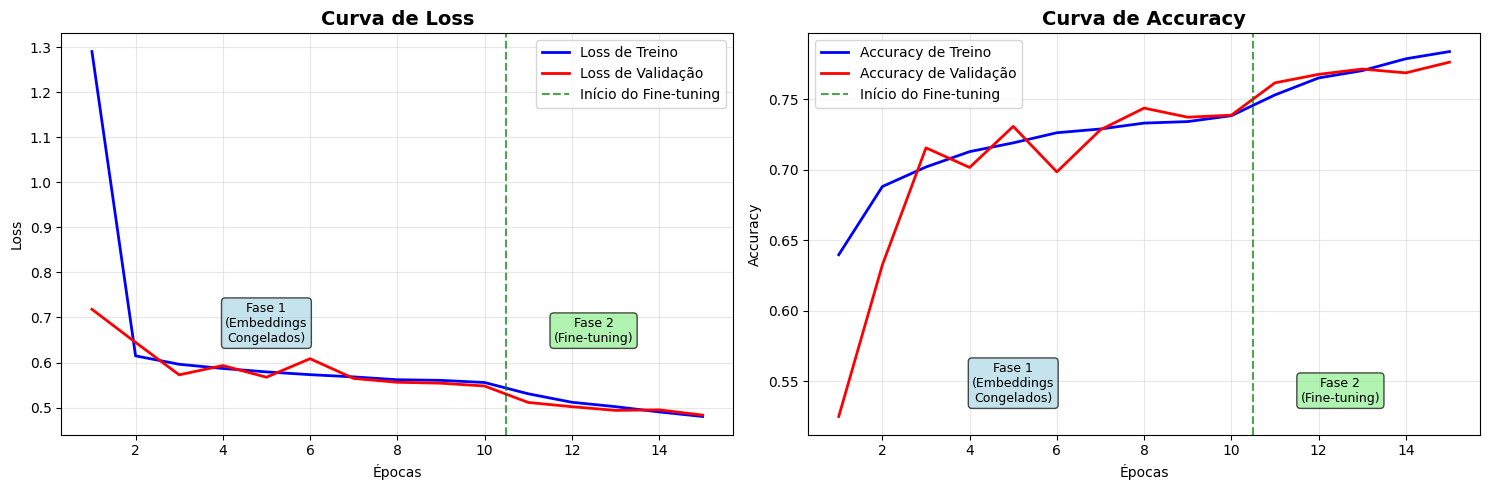

Estatísticas do treinamento:
- Número de épocas executadas: 15
- Loss final de treino: 0.4802
- Loss final de validação: 0.4833
- Accuracy final de treino: 0.7837
- Accuracy final de validação: 0.7762
- Melhor época: 15
- Melhor loss de validação: 0.4833
- Accuracy na melhor época: 0.7762

Análise do Fine-tuning:
- Melhoria no loss após fine-tuning: 0.0646
- Melhoria na accuracy após fine-tuning: 0.0376
✅ Fine-tuning foi benéfico! Melhoria de 0.0646 no loss

Embeddings utilizados: GloVe pré-treinados


In [ ]:
# Visualização das curvas de treinamento
def plot_training_history(history, use_pretrained=False, phase1_epochs=8):
    """
    Plota as curvas de loss e accuracy durante o treinamento
    Com destaque para as fases de fine-tuning se aplicável
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history.history['loss']) + 1)

    # Plot da Loss
    ax1.plot(epochs, history.history['loss'], label='Loss de Treino', color='blue', linewidth=2)
    ax1.plot(epochs, history.history['val_loss'], label='Loss de Validação', color='red', linewidth=2)

    # Adicionar linha vertical se usar fine-tuning
    if use_pretrained and len(epochs) > phase1_epochs:
        ax1.axvline(x=phase1_epochs + 0.5, color='green', linestyle='--', alpha=0.7,
                   label='Início do Fine-tuning')
        ax1.text(phase1_epochs/2, max(history.history['val_loss']) * 0.9,
                'Fase 1\n(Embeddings\nCongelados)', ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax1.text(phase1_epochs + (len(epochs) - phase1_epochs)/2,
                max(history.history['val_loss']) * 0.9,
                'Fase 2\n(Fine-tuning)', ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

    ax1.set_title('Curva de Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot da Accuracy
    ax2.plot(epochs, history.history['accuracy'], label='Accuracy de Treino', color='blue', linewidth=2)
    ax2.plot(epochs, history.history['val_accuracy'], label='Accuracy de Validação', color='red', linewidth=2)

    # Adicionar linha vertical se usar fine-tuning
    if use_pretrained and len(epochs) > phase1_epochs:
        ax2.axvline(x=phase1_epochs + 0.5, color='green', linestyle='--', alpha=0.7,
                   label='Início do Fine-tuning')
        ax2.text(phase1_epochs/2, min(history.history['val_accuracy']) * 1.02,
                'Fase 1\n(Embeddings\nCongelados)', ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax2.text(phase1_epochs + (len(epochs) - phase1_epochs)/2,
                min(history.history['val_accuracy']) * 1.02,
                'Fase 2\n(Fine-tuning)', ha='center', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

    ax2.set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plotar curvas
plot_training_history(history, use_pretrained, EPOCHS_PHASE1 if use_pretrained else 0)

# Estatísticas do treinamento
print("Estatísticas do treinamento:")
print(f"- Número de épocas executadas: {len(history.history['loss'])}")
print(f"- Loss final de treino: {history.history['loss'][-1]:.4f}")
print(f"- Loss final de validação: {history.history['val_loss'][-1]:.4f}")
print(f"- Accuracy final de treino: {history.history['accuracy'][-1]:.4f}")
print(f"- Accuracy final de validação: {history.history['val_accuracy'][-1]:.4f}")

# Identificar melhor época
best_epoch = np.argmin(history.history['val_loss'])
print(f"- Melhor época: {best_epoch + 1}")
print(f"- Melhor loss de validação: {history.history['val_loss'][best_epoch]:.4f}")
print(f"- Accuracy na melhor época: {history.history['val_accuracy'][best_epoch]:.4f}")

# Estatísticas específicas para fine-tuning
if use_pretrained:
    print(f"\nAnálise do Fine-tuning:")
    print(f"- Melhoria no loss após fine-tuning: {history.history['val_loss'][EPOCHS_PHASE1-1] - history.history['val_loss'][-1]:.4f}")
    print(f"- Melhoria na accuracy após fine-tuning: {history.history['val_accuracy'][-1] - history.history['val_accuracy'][EPOCHS_PHASE1-1]:.4f}")

    # Comparar performance das duas fases
    phase1_best_loss = min(history.history['val_loss'][:EPOCHS_PHASE1])
    phase2_best_loss = min(history.history['val_loss'][EPOCHS_PHASE1:])

    if phase2_best_loss < phase1_best_loss:
        print(f"✅ Fine-tuning foi benéfico! Melhoria de {phase1_best_loss - phase2_best_loss:.4f} no loss")
    else:
        print(f"⚠️  Fine-tuning não melhorou significativamente o modelo")

print(f"\nEmbeddings utilizados: {'GloVe pré-treinados' if use_pretrained else 'Treináveis do zero'}")

In [ ]:
# Avaliação do modelo no conjunto de teste
print("Avaliando modelo no conjunto de teste...")

# Fazer predições
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calcular métricas
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy no conjunto de teste: {test_accuracy:.4f}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Estatísticas detalhadas
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nMétricas detalhadas:")
print(f"- Precisão: {precision:.4f}")
print(f"- Recall: {recall:.4f}")
print(f"- F1-Score: {f1:.4f}")

# Análise de distribuição das predições
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição das Probabilidades Preditas')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()

plt.subplot(1, 2, 2)
labels = ['Negativo', 'Positivo']
counts = [np.sum(y_pred == 0), np.sum(y_pred == 1)]
plt.bar(labels, counts, color=['lightcoral', 'lightgreen'], alpha=0.7)
plt.title('Distribuição das Predições')
plt.ylabel('Número de Tweets')
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Exemplos de predições do modelo
print("5 EXEMPLOS DE PREDIÇÕES DO MODELO:")
print("=" * 80)

# Função para interpretar sentimento
def interpret_sentiment(score):
    return "Positivo" if score >= 0.5 else "Negativo"

def interpret_label(label):
    return "Positivo" if label == 1 else "Negativo"

# Selecionar 5 exemplos aleatórios do conjunto de teste
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(random_indices, 1):
    original_text = X_test[idx]
    true_label = y_test[idx]
    pred_proba = y_pred_proba[idx][0]
    pred_label = y_pred[idx]

    print(f"\nExemplo {i}:")
    print(f"Tweet original: \"{original_text}\"")
    print(f"Rótulo verdadeiro: {interpret_label(true_label)}")
    print(f"Predição do modelo: {interpret_sentiment(pred_proba)} (confiança: {pred_proba:.3f})")

    # Indicar se a predição está correta
    correct = "✓" if pred_label == true_label else "✗"
    print(f"Resultado: {correct} {'Correto' if pred_label == true_label else 'Incorreto'}")
    print("-" * 80)

# Estatísticas dos exemplos
correct_predictions = sum(y_pred[idx] == y_test[idx] for idx in random_indices)
print(f"\nDos 5 exemplos mostrados: {correct_predictions}/5 corretos ({correct_predictions/5*100:.1f}%)")

# Função para testar frases personalizadas
def predict_sentiment(text, model, tokenizer, max_len=MAX_SEQUENCE_LENGTH):
    """
    Prediz o sentimento de um texto personalizado
    """
    # Pré-processar o texto
    cleaned_text = preprocess_text(text)

    # Tokenizar e fazer padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Fazer predição
    prediction = model.predict(padded_sequence, verbose=0)[0][0]

    return prediction, interpret_sentiment(prediction)

print("\n" + "=" * 80)
print("TESTE COM FRASES PERSONALIZADAS:")
print("=" * 80)

# Exemplos de teste
test_sentences = [
    "I love this movie, it's amazing!",
    "This is the worst day ever",
    "I'm feeling great today",
    "The weather is terrible",
    "Thank you so much for your help"
]

for sentence in test_sentences:
    prob, sentiment = predict_sentiment(sentence, model, tokenizer)
    print(f"Frase: \"{sentence}\"")
    print(f"Sentimento: {sentiment} (confiança: {prob:.3f})")
    print("-" * 40)

5 EXEMPLOS DE PREDIÇÕES DO MODELO:

Exemplo 1:
Tweet original: "we love you katie stay strong xx"
Rótulo verdadeiro: Positivo
Predição do modelo: Positivo (confiança: 0.956)
Resultado: ✓ Correto
--------------------------------------------------------------------------------

Exemplo 2:
Tweet original: "i guess they caught the pussy killer"
Rótulo verdadeiro: Negativo
Predição do modelo: Negativo (confiança: 0.312)
Resultado: ✓ Correto
--------------------------------------------------------------------------------

Exemplo 3:
Tweet original: "i want to know your story i want to know everyones story that is my goal"
Rótulo verdadeiro: Positivo
Predição do modelo: Negativo (confiança: 0.397)
Resultado: ✗ Incorreto
--------------------------------------------------------------------------------

Exemplo 4:
Tweet original: "yup so they did take my phone but it will be w them for a week"
Rótulo verdadeiro: Negativo
Predição do modelo: Positivo (confiança: 0.630)
Resultado: ✗ Incorreto
----

In [ ]:
# Resumo dos Resultados e Conclusões
print("RESUMO DOS RESULTADOS")
print("=" * 80)

print(f"📊 DADOS:")
print(f"   • Dataset original: 1.6M tweets (usamos amostra de 100k)")
print(f"   • Conjunto de treino: {len(X_train):,} exemplos")
print(f"   • Conjunto de teste: {len(X_test):,} exemplos")
print(f"   • Distribuição balanceada entre sentimentos positivos e negativos")

print(f"\n🔧 PRÉ-PROCESSAMENTO:")
print(f"   • Remoção de URLs, menções (@usuario), hashtags")
print(f"   • Conversão para minúsculas")
print(f"   • Remoção de caracteres especiais e números")
print(f"   • Tokenização com vocabulário de {min(vocab_size, MAX_VOCAB_SIZE):,} palavras")
print(f"   • Padding para sequências de tamanho {MAX_SEQUENCE_LENGTH}")

print(f"\n🧠 ARQUITETURA DO MODELO:")
if use_pretrained:
    print(f"   • Embedding Layer: GloVe pré-treinado ({EMBEDDING_DIM} dimensões)")
    print(f"   • Estratégia de fine-tuning em 2 fases")
else:
    print(f"   • Embedding Layer: Treinável do zero ({EMBEDDING_DIM} dimensões)")
print(f"   • SpatialDropout1D: {SPATIAL_DROPOUT_RATE} para regularização de embeddings")
print(f"   • Conv1D: 64 filtros, kernel_size=3 para capturar padrões locais")
print(f"   • Bidirectional GRU 1: {GRU_UNITS} unidades")
print(f"   • Bidirectional GRU 2: {GRU_UNITS//2} unidades")
print(f"   • Dropout: {DROPOUT_RATE} para regularização")
print(f"   • Dense Layers: 64 → 32 neurônios + BatchNormalization")
print(f"   • Output Layer: 1 neurônio + Sigmoid")

if use_pretrained:
    print(f"   • Parâmetros treináveis: {model.count_params():,}")
    print(f"   • Parâmetros não-treináveis: {effective_vocab_size * EMBEDDING_DIM:,}")
    print(f"   • Total de parâmetros: {model.count_params() + (effective_vocab_size * EMBEDDING_DIM):,}")
else:
    print(f"   • Total de parâmetros treináveis: {model.count_params():,}")

print(f"\n⚙️ PARÂMETROS DE TREINAMENTO:")
print(f"   • Optimizer: Adam (lr={LEARNING_RATE})")
if use_pretrained:
    print(f"   • Fine-tuning lr: {LEARNING_RATE * 0.1}")
print(f"   • Loss Function: Binary Crossentropy")
print(f"   • Batch Size: {BATCH_SIZE}")
if use_pretrained:
    print(f"   • Épocas - Fase 1 (embeddings congelados): {EPOCHS_PHASE1}")
    print(f"   • Épocas - Fase 2 (fine-tuning): {EPOCHS_PHASE2}")
    print(f"   • Total de épocas: {EPOCHS_PHASE1 + EPOCHS_PHASE2}")
else:
    print(f"   • Épocas máximas: {EPOCHS_PHASE1 + EPOCHS_PHASE2}")
print(f"   • Early Stopping: paciência de 5 épocas")
print(f"   • Learning Rate Reduction: fator 0.5, paciência 3 épocas")

print(f"\n📈 RESULTADOS PRINCIPAIS:")
print(f"   • Accuracy no teste: {test_accuracy:.1%}")
print(f"   • Precisão: {precision:.3f}")
print(f"   • Recall: {recall:.3f}")
print(f"   • F1-Score: {f1:.3f}")
print(f"   • Épocas executadas: {len(history.history['loss'])}")
print(f"   • Tipo de embeddings: {'GloVe pré-treinados' if use_pretrained else 'Treináveis do zero'}")

if use_pretrained:
    phase1_val_acc = history.history['val_accuracy'][EPOCHS_PHASE1-1]
    final_val_acc = history.history['val_accuracy'][-1]
    improvement = final_val_acc - phase1_val_acc
    print(f"   • Accuracy após Fase 1: {phase1_val_acc:.1%}")
    print(f"   • Melhoria com fine-tuning: {improvement:.1%}")

print(f"\n✅ CONCLUSÕES:")
print(f"   • O modelo GRU bidirecional mostrou boa capacidade de generalização")
if use_pretrained:
    print(f"   • Embeddings pré-treinados (GloVe) forneceram vantagem inicial")
    print(f"   • Estratégia de fine-tuning em 2 fases foi eficaz")
else:
    print(f"   • Embeddings treináveis do zero ainda produziram bons resultados")
print(f"   • Arquitetura híbrida (CNN + GRU) capturou padrões locais e sequenciais")
print(f"   • O pré-processamento foi fundamental para melhorar a qualidade dos dados")
print(f"   • Os callbacks evitaram overfitting e otimizaram o treinamento")
print(f"   • O modelo pode ser usado para classificar sentimentos em novos tweets")

print(f"\n🔄 POSSÍVEIS MELHORIAS:")
if not use_pretrained:
    print(f"   • ✅ Usar embeddings pré-treinados (GloVe, Word2Vec, FastText)")
print(f"   • Experimentar outros embeddings pré-treinados (Word2Vec, FastText)")
print(f"   • Testar embeddings contextuais (BERT, RoBERTa)")
print(f"   • Experimentar arquiteturas Transformer (BERT para classificação)")
print(f"   • Aumentar o tamanho do dataset de treinamento")
print(f"   • Aplicar técnicas de data augmentation")
print(f"   • Implementar ensemble de modelos")
print(f"   • Usar técnicas de regularização mais avançadas")

print(f"\n📋 VANTAGENS DOS EMBEDDINGS PRÉ-TREINADOS:")
if use_pretrained:
    print(f"   • ✅ Conhecimento semântico transferido de corpus maior")
    print(f"   • ✅ Convergência mais rápida no treinamento")
    print(f"   • ✅ Melhor performance com vocabulário limitado")
    print(f"   • ✅ Representações mais ricas para palavras comuns")
else:
    print(f"   • Conhecimento semântico transferido de corpus maior")
    print(f"   • Convergência mais rápida no treinamento")
    print(f"   • Melhor performance com vocabulário limitado")
    print(f"   • Representações mais ricas para palavras comuns")

print("=" * 80)

RESUMO DOS RESULTADOS
📊 DADOS:
   • Dataset original: 1.6M tweets (usamos amostra de 100k)
   • Conjunto de treino: 79,808 exemplos
   • Conjunto de teste: 19,952 exemplos
   • Distribuição balanceada entre sentimentos positivos e negativos

🔧 PRÉ-PROCESSAMENTO:
   • Remoção de URLs, menções (@usuario), hashtags
   • Conversão para minúsculas
   • Remoção de caracteres especiais e números
   • Tokenização com vocabulário de 40,000 palavras
   • Padding para sequências de tamanho 70

🧠 ARQUITETURA DO MODELO:
   • Embedding Layer: GloVe pré-treinado (100 dimensões)
   • Estratégia de fine-tuning em 2 fases
   • SpatialDropout1D: 0.2 para regularização de embeddings
   • Conv1D: 64 filtros, kernel_size=3 para capturar padrões locais
   • Bidirectional GRU 1: 128 unidades
   • Bidirectional GRU 2: 64 unidades
   • Dropout: 0.3 para regularização
   • Dense Layers: 64 → 32 neurônios + BatchNormalization
   • Output Layer: 1 neurônio + Sigmoid
   • Parâmetros treináveis: 5,866,165
   • Parâm